# Generate BlockTower Datasets

Here we generate datasets and store them on [huggingface](https://huggingface.co/docs/hub/en/datasets-overview).

We're going to generate datasets of different sizes (10k, 200k, 1M, 5M), varying the number of blocks from 3-6, always with a 50/50 stable/unstable split. The 10k dataset is only for testing/debugging/profiling.

We'll store one copy of the dataset with only the initial start_positions.

```
visionlab/block-towers-10k-init
visionlab/block-towers-200k-init
visionlab/block-towers-1M-init
visionlab/block-towers-5M-init
```

We'll store an additional copy that has the trajectory, first frame, and segmentation mask, while varying the scale factor (side_length = .4/scale). When scale = 1.0, the objects are "large" and so "fall slowly". When scale = 10, the objects are small, so "fall fast".

```
visionlab/block-towers-10k-trajectory-scale1
visionlab/block-towers-200k-trajectory-scale1
visionlab/block-towers-1M-trajectory-scale1
visionlab/block-towers-5M-trajectory-scale1
```

```
visionlab/block-towers-10k-trajectory-scale10
visionlab/block-towers-200k-trajectory-scale10
visionlab/block-towers-1M-trajectory-scale10
visionlab/block-towers-5M-trajectory-scale10
```

Finally, we can either use these settings, where the towers yield approximately 50/50 stable/unstable (lower std needed for the taller towers):
```
settings1 = {
    3: dict(num_blocks=3, side_length=.40, std=.350, truncate=.75),
    4: dict(num_blocks=4, side_length=.40, std=.280, truncate=.65),
    5: dict(num_blocks=5, side_length=.40, std=.165, truncate=.65),
    6: dict(num_blocks=6, side_length=.40, std=.130, truncate=.65),
}
```

Or we can use fixed variance/truncation param for all towers, and just over-generate to sample a 50/50 split of stable/unstable towers.
```
settings2 = {
    3: dict(num_blocks=3, side_length=.40, std=.350, truncate=.60),
    4: dict(num_blocks=4, side_length=.40, std=.350, truncate=.60),
    5: dict(num_blocks=5, side_length=.40, std=.350, truncate=.60),
    6: dict(num_blocks=6, side_length=.40, std=.350, truncate=.60),
}
```

In [1]:
%config InlineBackend.figure_format = 'retina'

# Generate Datasets

In [2]:
%load_ext autoreload
%autoreload 2

In [34]:
from block_towers.cubes import gen_start_positions_cubes
from block_towers.simulation import generate_batch_initial_positions
from block_towers.render import show_tower_grid

In [5]:
# settings where naturally get 50/50
settings1 = {
    3: dict(num_blocks=3, side_length=.40, std=.350, truncate=.75),
    4: dict(num_blocks=4, side_length=.40, std=.280, truncate=.65),
    5: dict(num_blocks=5, side_length=.40, std=.165, truncate=.65),
    6: dict(num_blocks=6, side_length=.40, std=.130, truncate=.65),
}

# fixed params, so we need to generate more large towers to get a 50/50 subset
settings2 = {
    3: dict(num_blocks=3, side_length=.40, std=.350, truncate=.60),
    4: dict(num_blocks=4, side_length=.40, std=.350, truncate=.60),
    5: dict(num_blocks=5, side_length=.40, std=.350, truncate=.60),
    6: dict(num_blocks=6, side_length=.40, std=.350, truncate=.60),
}

In [7]:
generate_batch_initial_positions?

Signature:
generate_batch_initial_positions(
    gen_fun,
    num_blocks=3,
    side_length=0.4,
    std=0.35,
    truncate=0.6,
    num_samples=1000,
    pct_fall=0.5,
    mb=None,
)
Docstring: <no docstring>
File:      ~/work/GitHub/block-towers/block_towers/simulation.py
Type:      function

In [71]:
num_blocks = 3
params = settings1[num_blocks]
stable, unstable = generate_batch_initial_positions(gen_start_positions_cubes, 
                                                    **params, num_samples=10000, pct_fall=.50)

stable, unstable = generate_batch_initial_positions(gen_start_positions_cubes, 
                                                    **params, num_samples=200000, pct_fall=.50)

len(stable), len(unstable)

(100000, 100000)

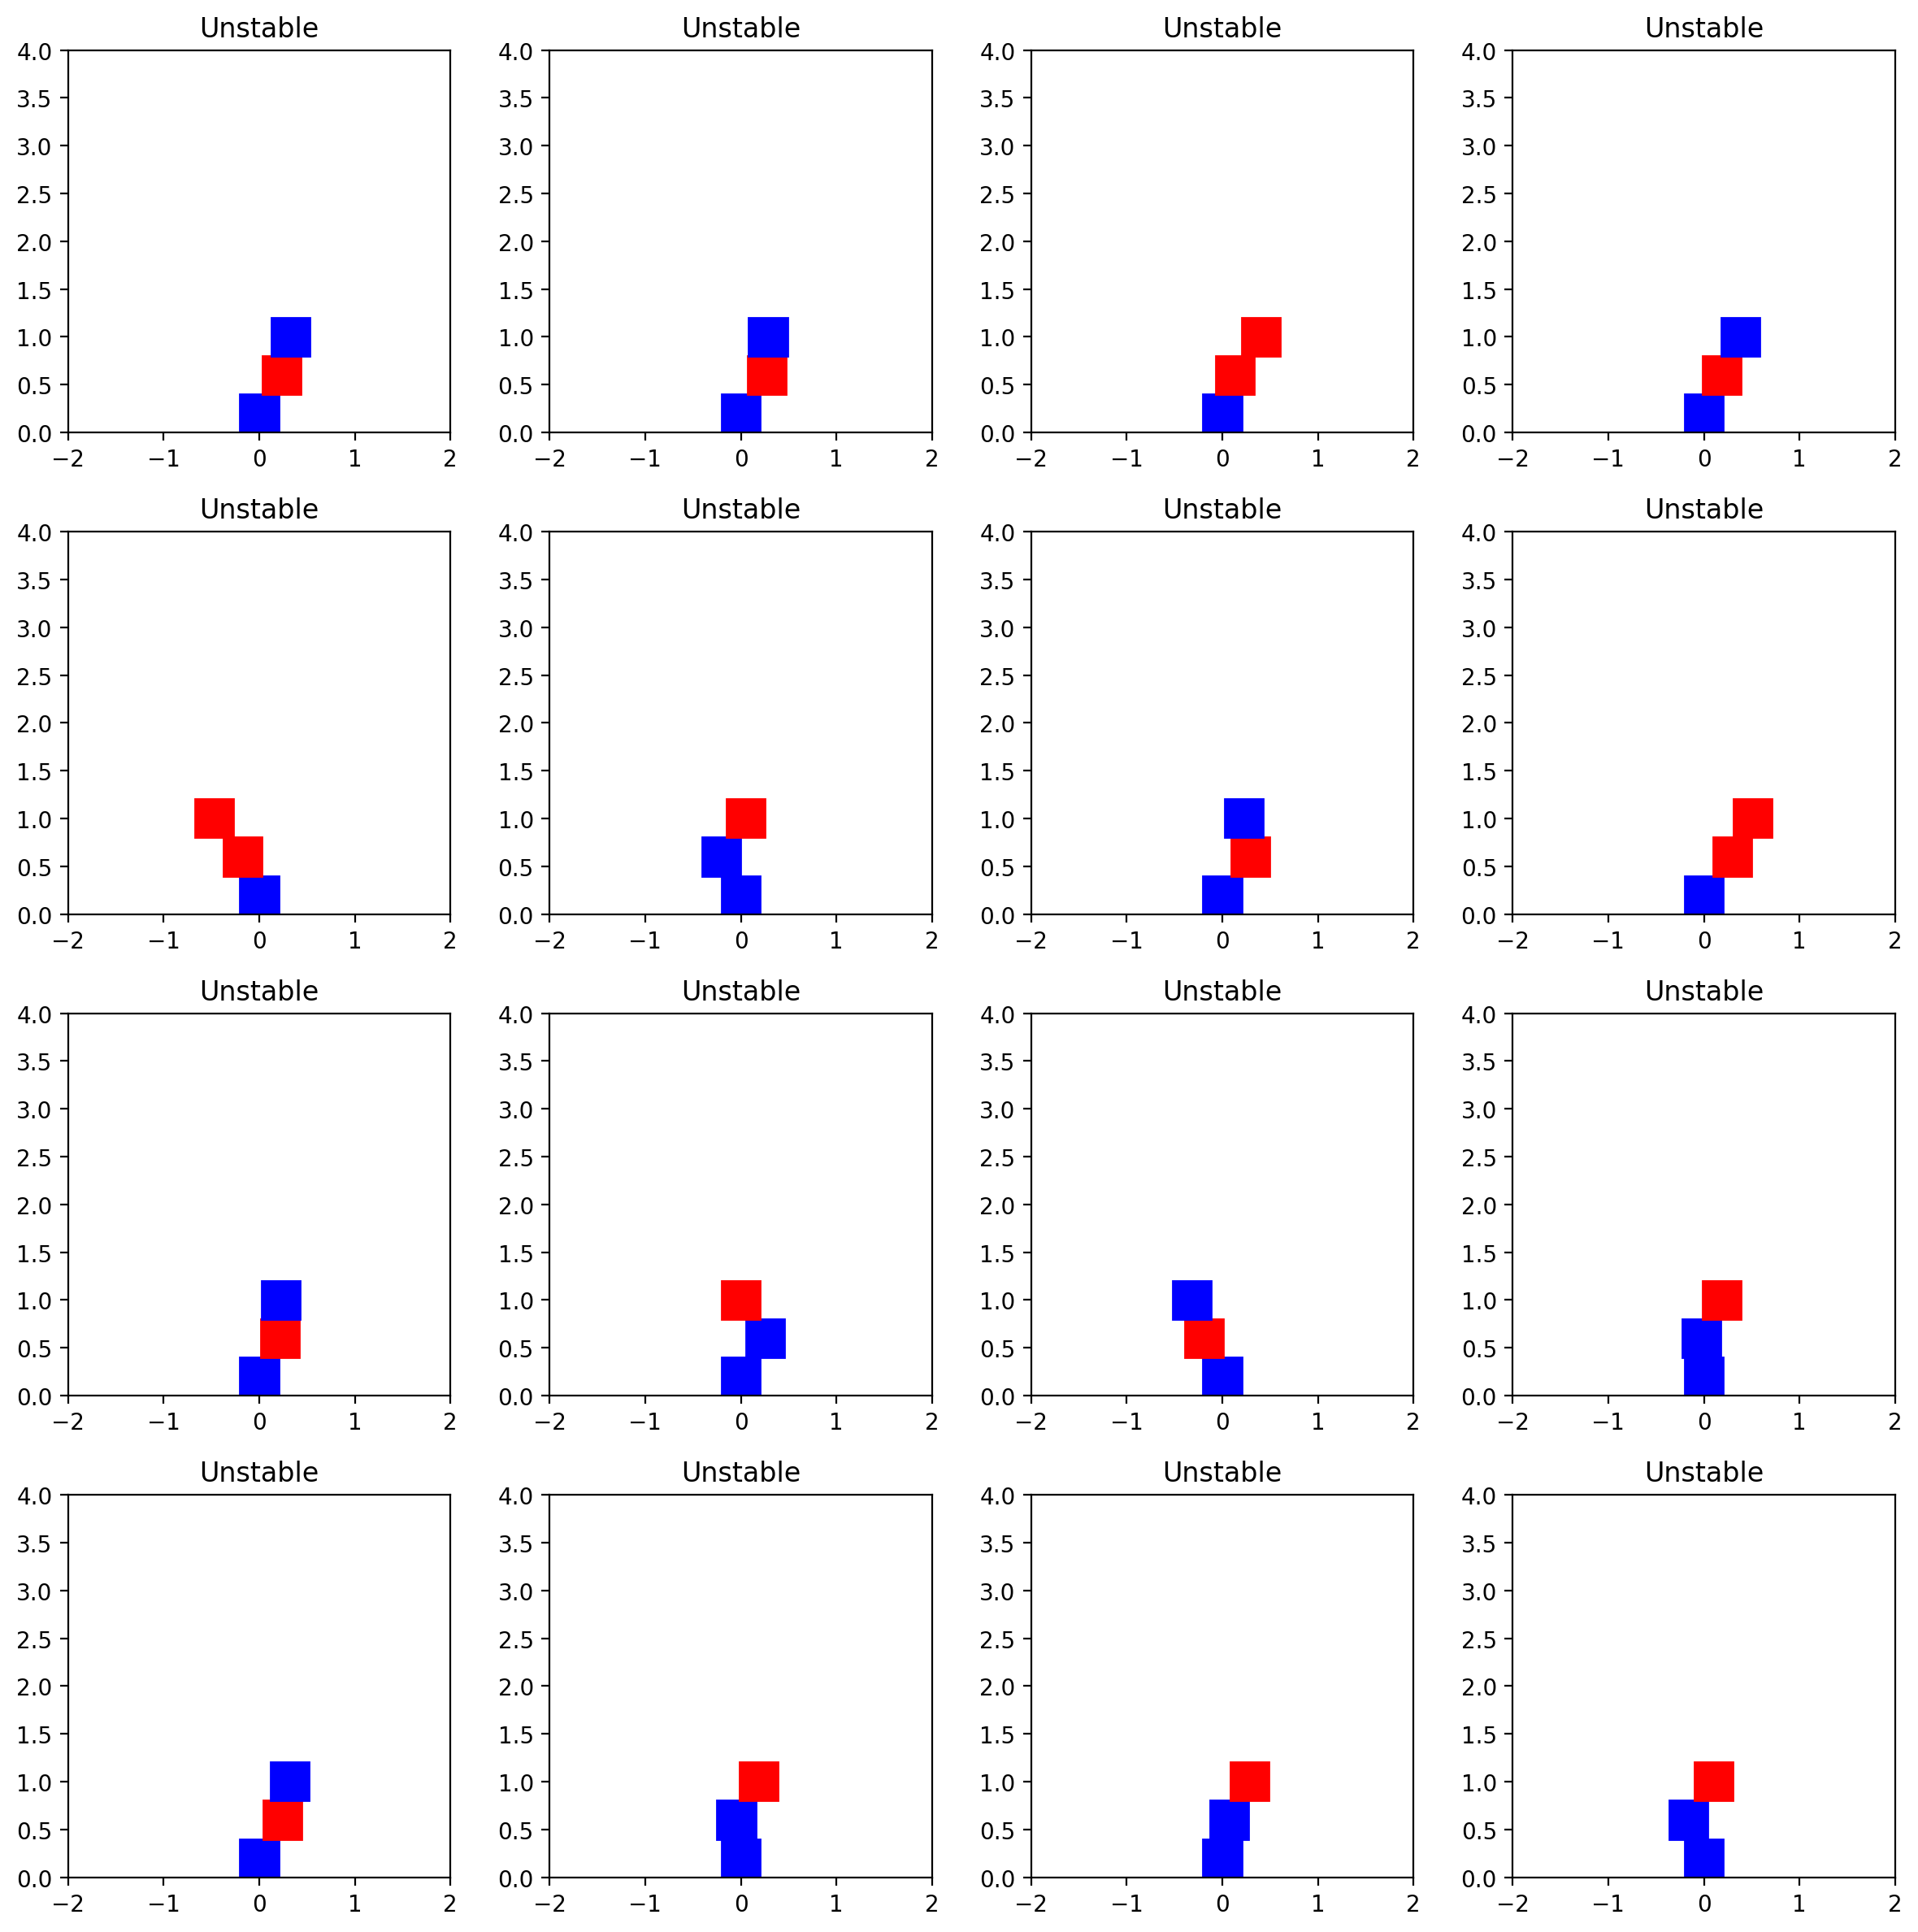

In [13]:
show_tower_grid(unstable[0:16])

In [12]:
from fastprogress import progress_bar

In [6]:
from block_towers.datasets import settings1, generate_blocktower_dataset
from block_towers.cubes import gen_start_positions_cubes
from datasets import Dataset, DatasetDict, concatenate_datasets

dataset = generate_blocktower_dataset(settings1, gen_start_positions_cubes, 
                                      num_samples=1000, pct_fall=.50, test_size=.20)
dataset

Map: 100%|██████████| 500/500 [00:00<00:00, 12999.55 examples/s]


Map: 100%|██████████| 500/500 [00:00<00:00, 10998.63 examples/s]


Map: 100%|██████████| 500/500 [00:00<00:00, 9700.10 examples/s]


Map: 100%|██████████| 500/500 [00:00<00:00, 3608.36 examples/s]


DatasetDict({
    stack3_stable: DatasetDict({
        train: Dataset({
            features: ['data', 'label', 'num_blocks'],
            num_rows: 400
        })
        test: Dataset({
            features: ['data', 'label', 'num_blocks'],
            num_rows: 100
        })
    })
    stack3_unstable: DatasetDict({
        train: Dataset({
            features: ['data', 'label', 'num_blocks'],
            num_rows: 400
        })
        test: Dataset({
            features: ['data', 'label', 'num_blocks'],
            num_rows: 100
        })
    })
    stack4_stable: DatasetDict({
        train: Dataset({
            features: ['data', 'label', 'num_blocks'],
            num_rows: 400
        })
        test: Dataset({
            features: ['data', 'label', 'num_blocks'],
            num_rows: 100
        })
    })
    stack4_unstable: DatasetDict({
        train: Dataset({
            features: ['data', 'label', 'num_blocks'],
            num_rows: 400
        })
        test:

In [13]:
# Combine the two training datasets
combined_train = concatenate_datasets([v['train'] for k,v in dataset.items()])
combined_test = concatenate_datasets([v['test'] for k,v in dataset.items()])

# Then concatenate
print(combined_train)
print(combined_test)

Dataset({
    features: ['data', 'label', 'num_blocks'],
    num_rows: 3200
})
Dataset({
    features: ['data', 'label', 'num_blocks'],
    num_rows: 800
})


In [31]:
for example in progress_bar(combined_train):
    print(example['data'])
    print(example['label'])
    print(example['num_blocks'])
    break

[{'density': None, 'lx': 0.4, 'ly': 0.4, 'lz': 0.4, 'mass': None, 'rx': 0, 'ry': 0, 'rz': 0, 'unstable': 0, 'x': 0.0, 'y': 0, 'z': 0.2}, {'density': None, 'lx': 0.4, 'ly': 0.4, 'lz': 0.4, 'mass': None, 'rx': 0, 'ry': 0, 'rz': 0, 'unstable': 0, 'x': -0.04830358505550802, 'y': 0, 'z': 0.6000000000000001}, {'density': None, 'lx': 0.4, 'ly': 0.4, 'lz': 0.4, 'mass': None, 'rx': 0, 'ry': 0, 'rz': 0, 'unstable': 0, 'x': 0.01899764410539364, 'y': 0, 'z': 1.0}]
0
3


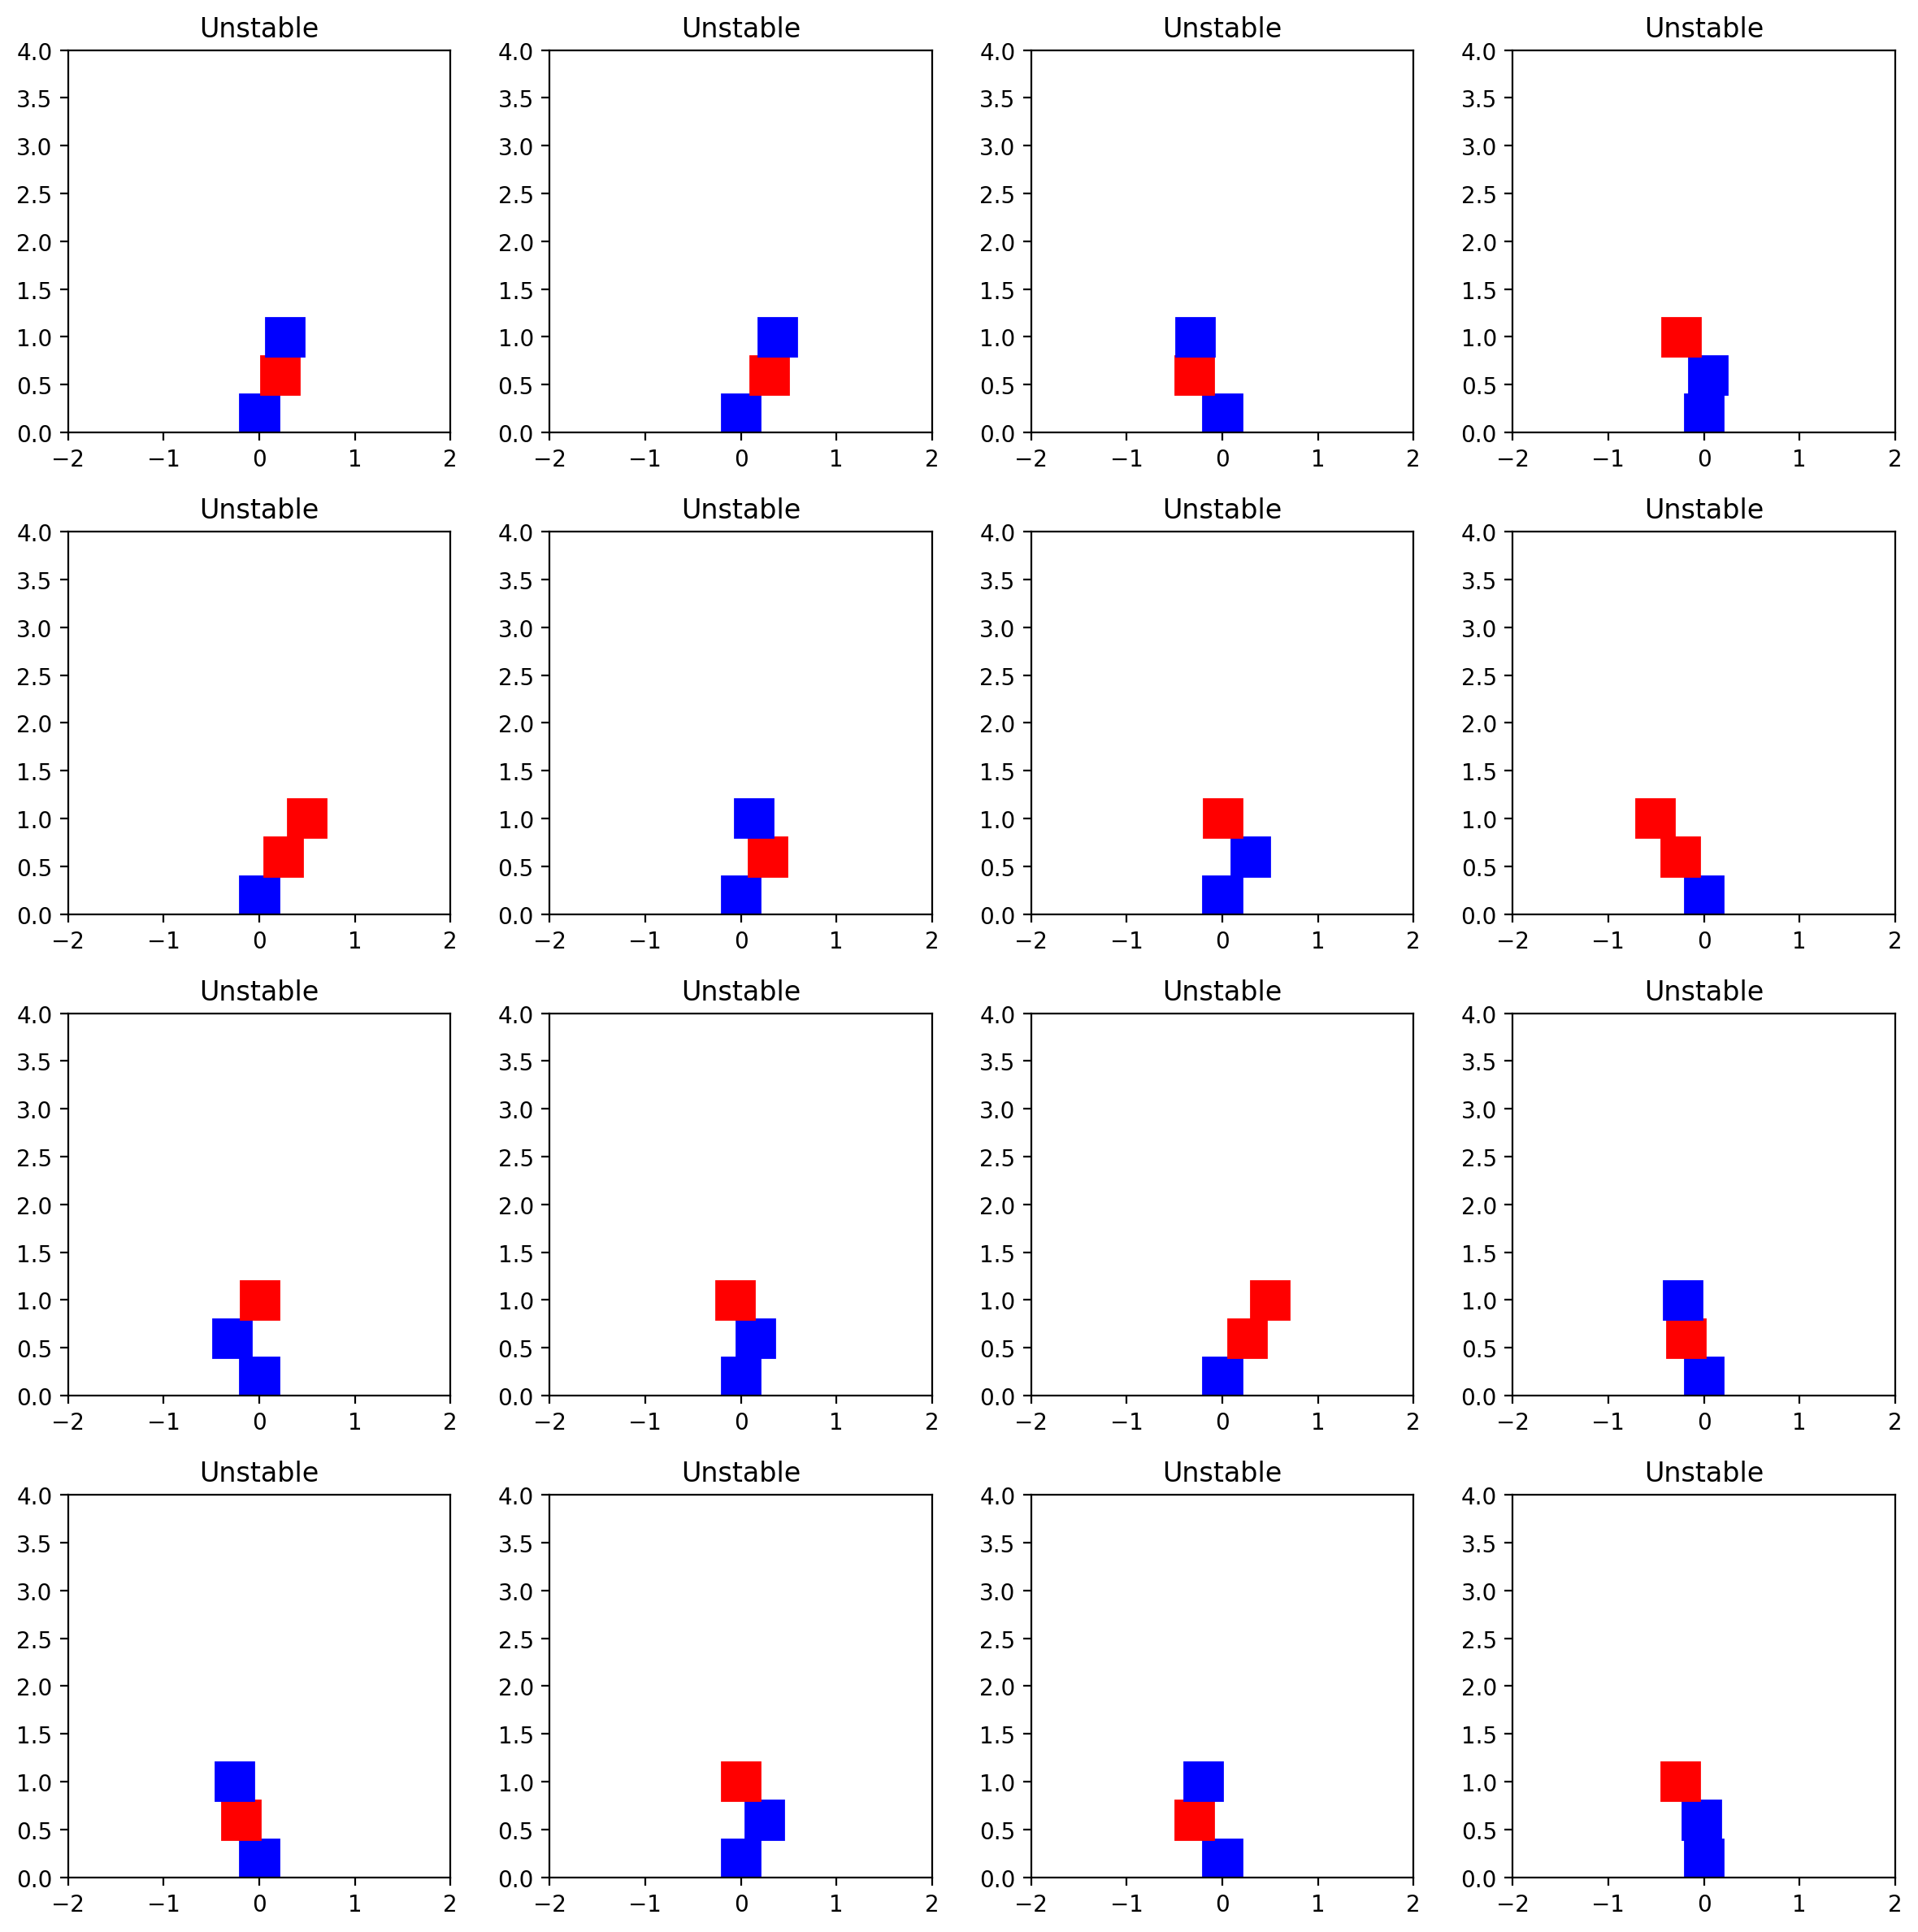

In [36]:
show_tower_grid(dataset['stack3_unstable']['train']['data'][0:16])

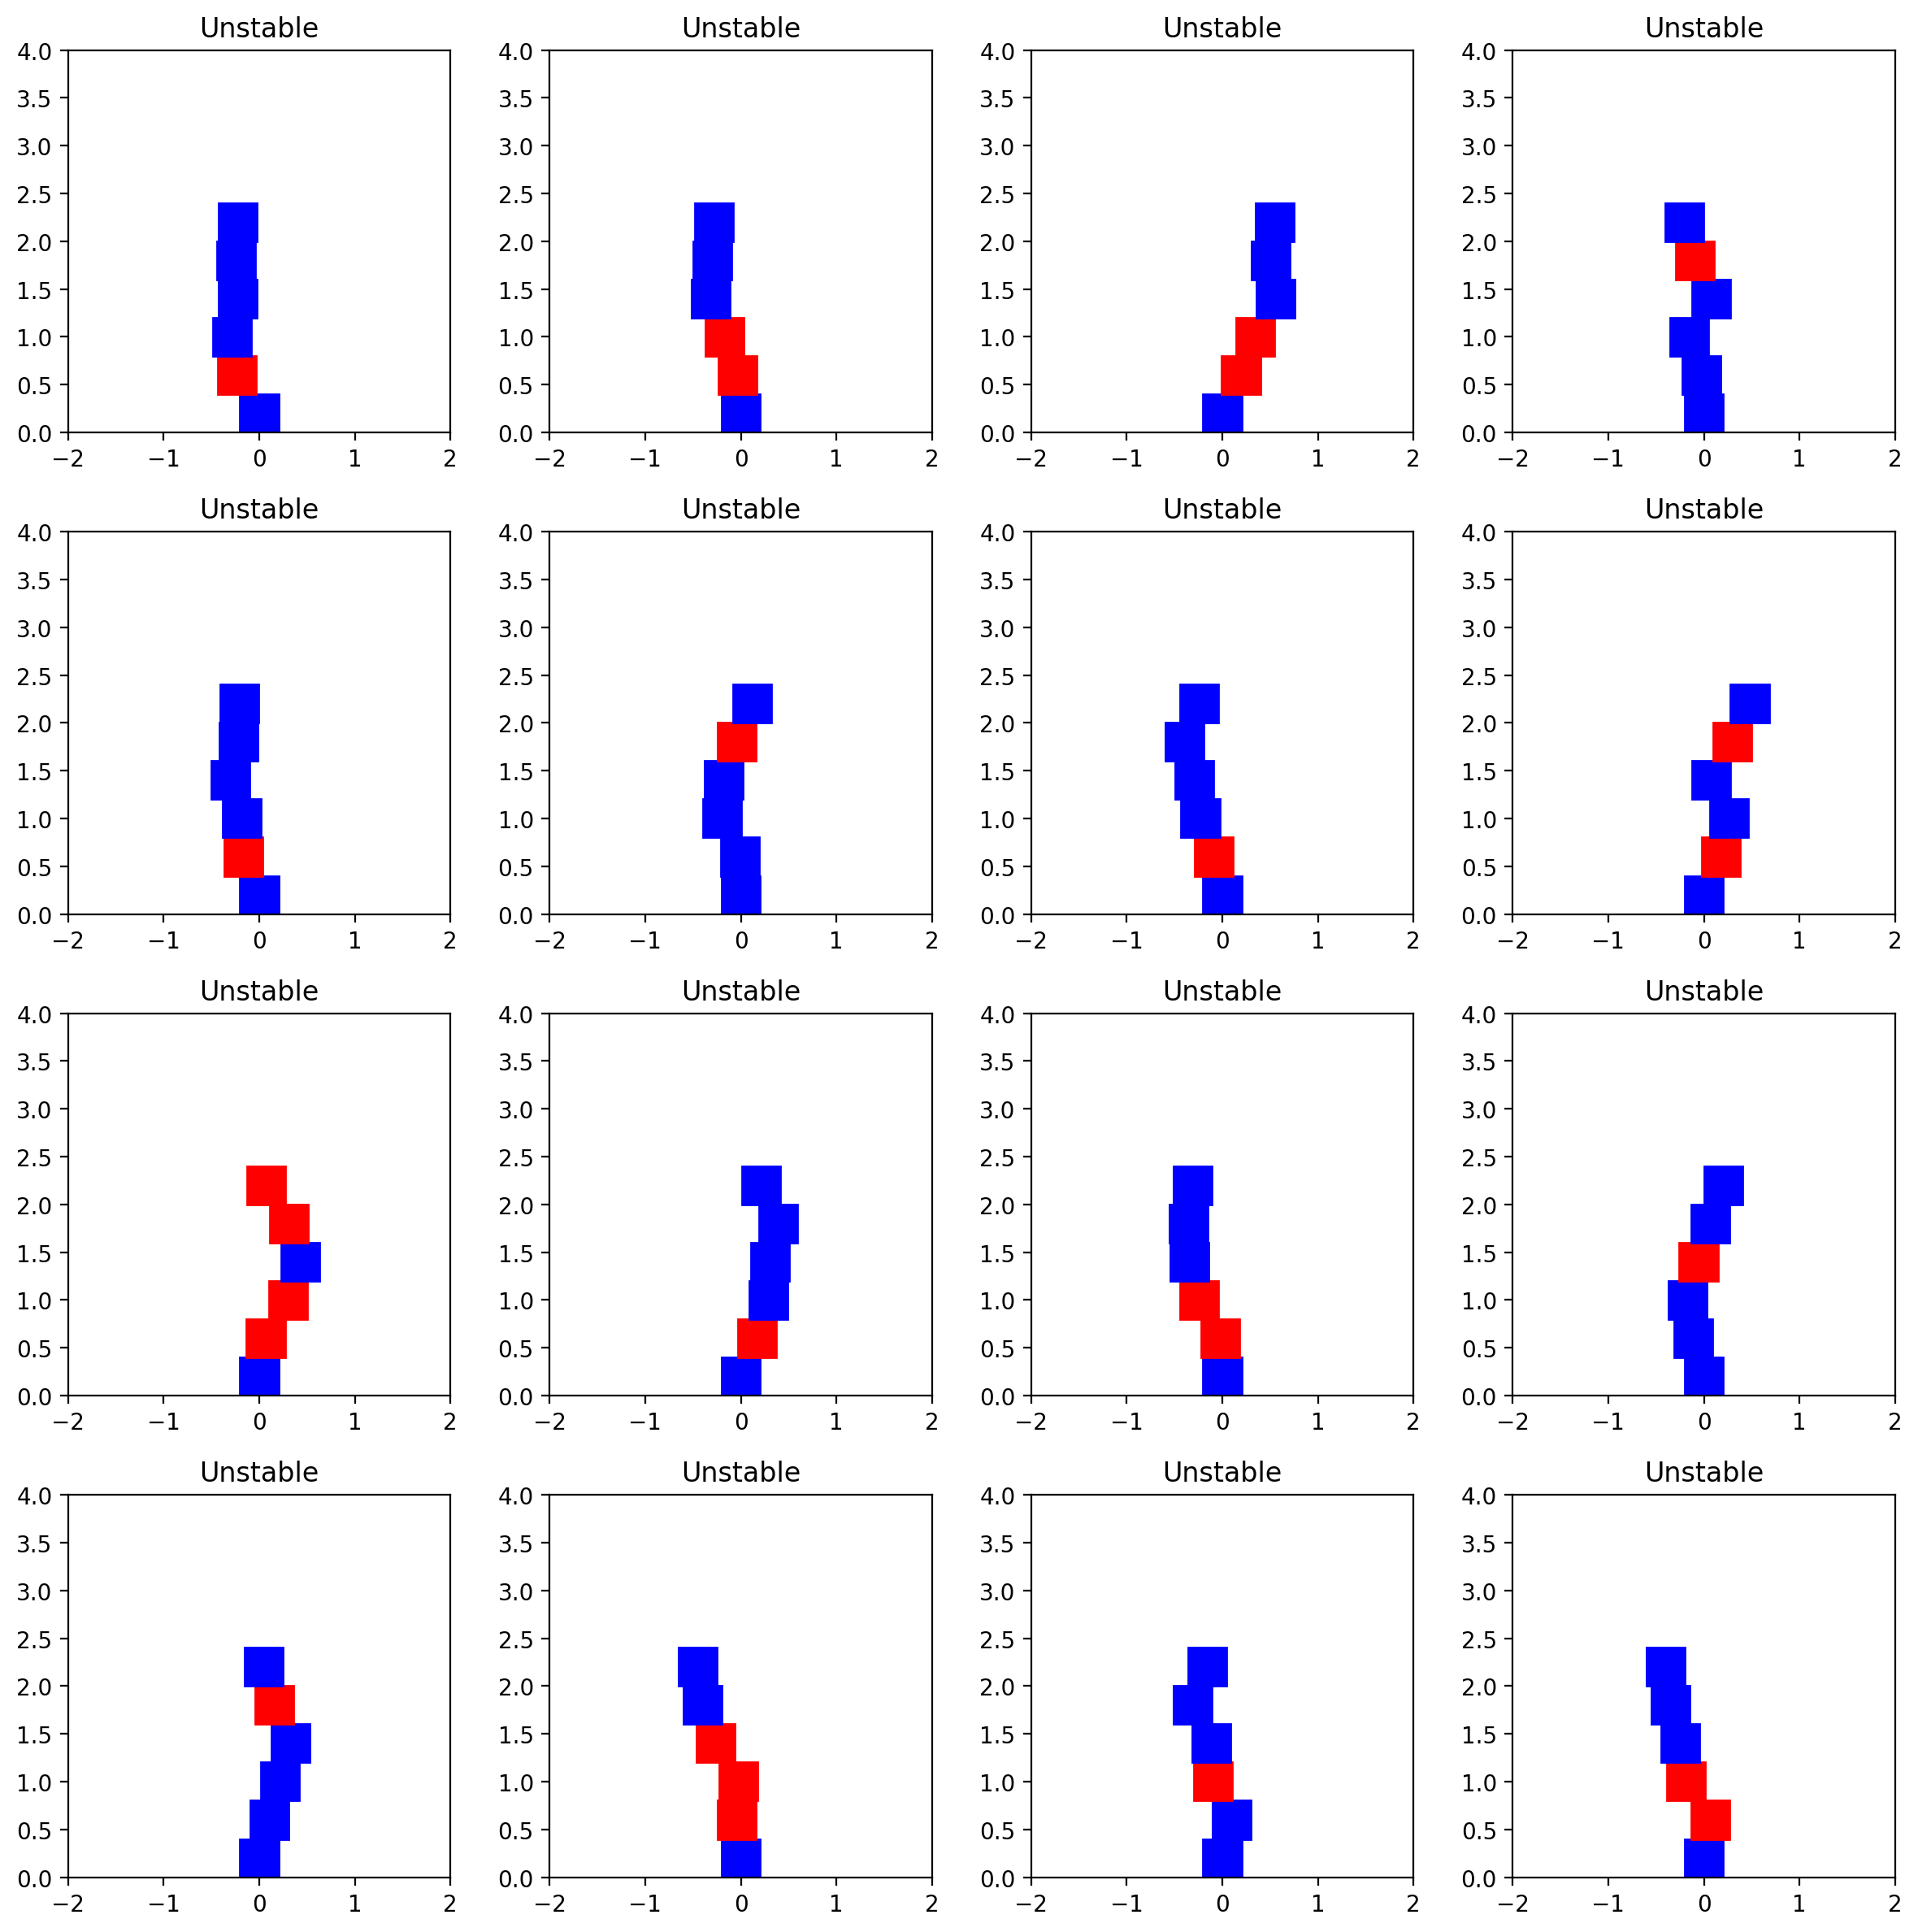

In [37]:
show_tower_grid(dataset['stack6_unstable']['train']['data'][0:16])

# test huggingface dataset loading

In [39]:
from datasets import load_dataset

dataset = load_dataset("visionlab/block_towers_test")
dataset

DatasetDict({
    stack3_stable: Dataset({
        features: ['data'],
        num_rows: 5000
    })
    stack3_unstable: Dataset({
        features: ['data'],
        num_rows: 5000
    })
    stack4_stable: Dataset({
        features: ['data'],
        num_rows: 5000
    })
    stack4_unstable: Dataset({
        features: ['data'],
        num_rows: 5000
    })
    stack5_stable: Dataset({
        features: ['data'],
        num_rows: 5000
    })
    stack5_unstable: Dataset({
        features: ['data'],
        num_rows: 5000
    })
    stack6_stable: Dataset({
        features: ['data'],
        num_rows: 5000
    })
    stack6_unstable: Dataset({
        features: ['data'],
        num_rows: 5000
    })
})

In [44]:
len(dataset['stack3_stable']['data'][0])

3

In [27]:
split_dataset = dataset.train_test_split(test_size=0.2)  # Adjust as needed
split_dataset

AttributeError: 'DatasetDict' object has no attribute 'train_test_split'